In [115]:
import pandas as pd
import ast as ast
import numpy as np
from typing import *
import seaborn as sns
import matplotlib.pyplot as plt
from task_2_helpers import *
from transformers import pipeline

### Data Read

In [146]:
# df_business = pd.read_parquet('data/ATML2024_businesses.parquet')
df_business = pd.read_csv('data/ATML2024_businesses.csv', header=0)

# df_Train_reviews = pd.read_parquet('data/ATML2024_reviews_train.parquet')
df_Train_reviews = pd.read_csv('data/ATML2024_reviews_train.csv', header=0)

# df_users = pd.read_parquet('data/ATML2024_users.parquet')
df_users = pd.read_csv('data/ATML2024_users.csv', header=0, nrows=100)

# See TO DO....

In [143]:
# Load NLP models
classifier = pipeline('zero-shot-classification', model="facebook/bart-large-mnli") # TO DO: user a better model
sent_pipe = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")

c:\Users\Alexis\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBartForSequenceClassification: ['model.decoder.version', 'model.encoder.version']
- This IS expected if you are initializing TFBartForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBartForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBartForS

### Cleanup business data columns

In [147]:
# Convert dictionary columns to the correct types @@@@ Run only once
df_business = df_business[df_business['city'] == 'Philadelphia']
df_business['attributes'] = df_business['attributes'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())
df_business['hours'] = df_business['hours'].apply(lambda x: ast.literal_eval(x) if not pd.isna(x) or not pd.isnull(x)  else dict())

# df_business['weekend'] = df_business['hours'].apply(lambda x: extract_weekend_value(x))
df_business['hours_list'] = df_business['hours'].apply(lambda x: extract_hours_value(x))
df_business['attributes_list'] = df_business['attributes'].apply(lambda x: sorted(extract_attributes_value(x)))
df_business['categories_list'] = df_business['categories'].apply(lambda x: sorted(map(lambda a: a.strip().lower(),  x.split(',')) ) if isinstance(x, str) else [])

### Join Business Data With Ratings Data

In [148]:
# Join the two datasets
df_business_data = df_business[['business_id', 'postal_code', 'attributes_list', 'hours_list', 'categories_list']]
df_ratings_data = df_Train_reviews[['business_id', 'rating', 'useful', 'funny', 'cool', 'text']]
df_data = pd.merge(df_business_data, df_ratings_data, left_on= 'business_id', right_on='business_id')

# Keep only observation business in Philadelphia
df_data = df_data[df_data['postal_code'].astype(str).str.startswith('191')]
# Keep only values with "restaurants"
df_data = df_data[df_data['categories_list'].apply(lambda lst: any('restaurants' in str(item).lower() for item in lst))]
df_data

,business_id,postal_code,attributes_list,hours_list,categories_list,rating,useful,funny,cool,text
0,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,1,0,2,So I don't know how the other review was doubl...
1,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,0,I love this place.. I love their chunky fried...
2,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,0,0,1,I ordered so many cake from here for our famil...
3,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",4,0,0,0,Ordered a birthday cake here for the first tim...
4,wm9eoqjytVbC7dQcM4WSTM,19107,"[Alcohol, BikeParking, BusinessAcceptsCreditCa...","[[7.0, 20.0], [7.0, 20.0], [7.0, 20.0], [7.0, ...","[bakeries, bubble tea, coffee & tea, food, res...",5,1,0,0,This is my favorite bakery in Chinatown! It's ...
...,...,...,...,...,...,...,...,...,...,...
144847,gSkyrataUwvsAMli-L39n8,19104,"[Alcohol, Ambience, BikeParking, BusinessAccep...","[[9.0, 19.5], [9.0, 19.5], [9.0, 19.5], [9.0, ...","[american (traditional), coffee & tea, food, r...",5,4,0,1,I don't know how this place doesn't have five ...
144870,QscEk0TPjLIlLgQzIN9TnW,19147,"[Alcohol, Ambience, BikeParking, BusinessAccep...","[[11.0, 22.0], [11.0, 22.0], [-1, -1], [11.0, ...","[mexican, restaurants]",5,2,1,1,First time trying this restaurant and I had a ...
144871,QscEk0TPjLIlLgQzIN9TnW,19147,"[Alcohol, Ambience, BikeParking, BusinessAccep...","[[11.0, 22.0], [11.0, 22.0], [-1, -1], [11.0, ...","[mexican, restaurants]",5,1,0,0,Amazing food and wonderful service! We got the...
144872,QscEk0TPjLIlLgQzIN9TnW,19147,"[Alcohol, Ambience, BikeParking, BusinessAccep...","[[11.0, 22.0], [11.0, 22.0], [-1, -1], [11.0, ...","[mexican, restaurants]",5,1,0,0,This hidden gem in south philly is why we need...


#### Assign positive or negative label to reviews and drop negatives

In [150]:
# USED On reduced data. Need to clean reviews because of max length in tokens allowed with models... 
df_data = df_data[:30]
#To be used for asssigning POSITIVE NEGATIVE. 

# Sentiments based on review
def sentiment(text):
    output = sent_pipe(text)[0]['label']
    return output

# Apply on dataset
df_data['sentiment'] = df_data['text'].apply(sentiment)

# Drop negative sentiments
df_data = df_data[df_data['sentiment'] != 'NEGATIVE']
df_data_full = df_data.copy()

#### Assign to each "attribute" a group 
The goal is, once filtered for positive reviews, we compute a mean rating per type of food
1. filter for positive reviews.
2. assign group to attributes
3. display a distribution per item of group
4. display a mean rating per item of group

#### 2

# See TO DO....
## Analyzing Categories
To do: 
1. Replace with full data


In [152]:
# All categories in a set
all_categories = set(np.concatenate(df_data.categories_list.values).ravel()) #df_data.categories_list.values.flatten()

# Replace list by unique element. (individualize /create new rows)
categories_individ_df = df_data.explode('categories_list')
categories_individ_df = categories_individ_df[categories_individ_df['categories_list'] != 'restaurants']
categories_individ_df = categories_individ_df[categories_individ_df['categories_list'] != 'food']

# TO DO: Define the groups we will keep
group_names = ["Ambiance", "Health", "Location", "Service Style", "Meal Type", "Type of Cuisine", "Pricing", "Alcohol"]
all_categories = {"wine", "sandwiches", "bakeries","japanese"} # TO BE REMOVED ( we will use all_categories from above)

# Define group
CategoryLabel = {}

# Assign a group to categories
for category in all_categories:
    output = classifier(category, group_names)
    CategoryLabel[category] = output['labels'][0]

print(CategoryLabel)

categories_individ_df["group_categorie"] = categories_individ_df["categories_list"].map(CategoryLabel)

{'japanese': 'Type of Cuisine', 'bakeries': 'Meal Type', 'sandwiches': 'Meal Type', 'wine': 'Alcohol'}


#### Frequency of items in Attributes

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3739714355.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')


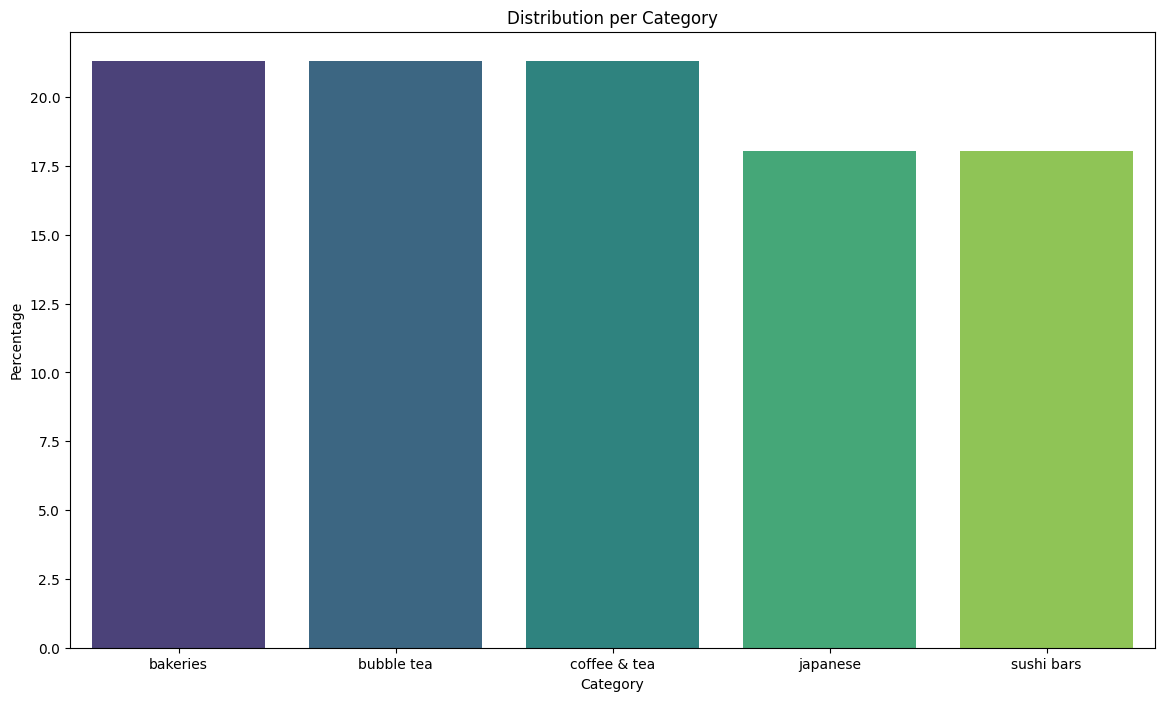

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3739714355.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')


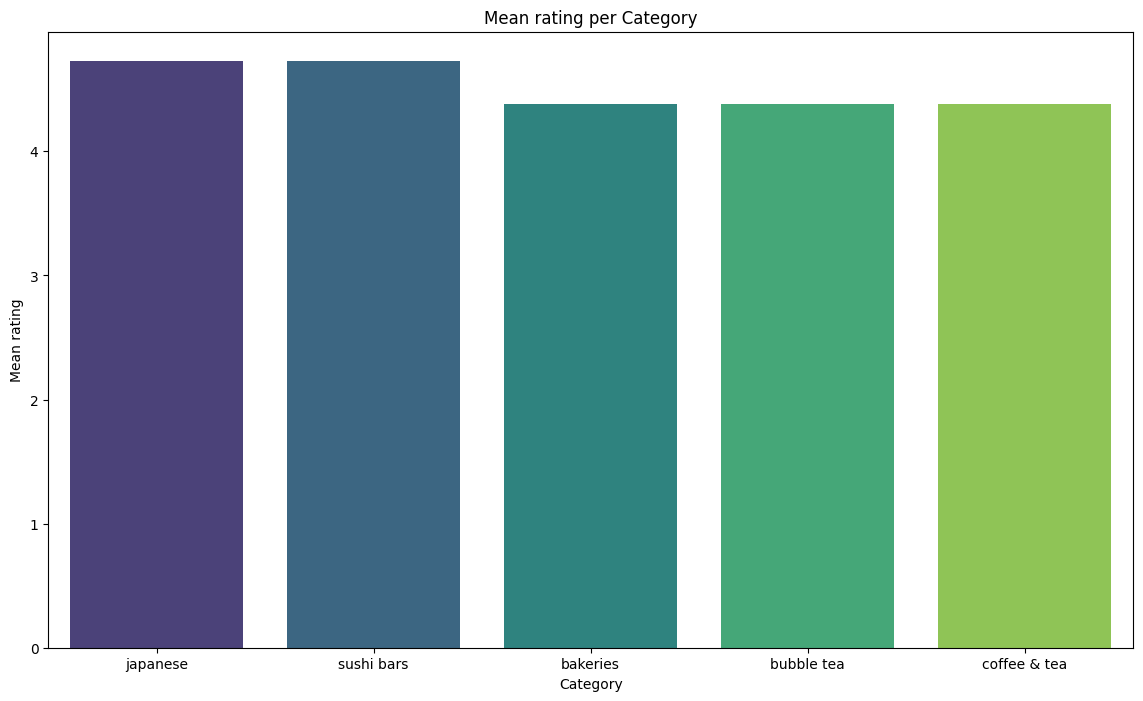

In [160]:
###############
# Percentage per category
category_counts = categories_individ_df['categories_list'].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ['category', 'percentage']
plt.figure(figsize=(14, 8))
plt.title('Distribution per Category')
sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()


###############
# Averaging the ratings per category

# Plot
mean_ratings = categories_individ_df.groupby('categories_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(14, 8))
plt.title('Mean rating per Category')
sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Mean rating')
plt.show()

#### PLOT PER CATEGORY

TO COMPLETE (SEE ATTRIBUTES)

In [163]:
# Mean rating per category
mean_ratings["group_category"] = mean_ratings["categories_list"].map(CategoryLabel)
mean_ratings = mean_ratings.groupby(['group_category', 'categories_list'])['rating'].mean().reset_index()
mean_ratings = mean_ratings[mean_ratings['rating'] >= 3.6]
mean_ratings

,group_category,categories_list,rating
0,Meal Type,bakeries,4.384615
1,Type of Cuisine,japanese,4.727273


C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3313449418.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=filtered_df, palette='viridis')


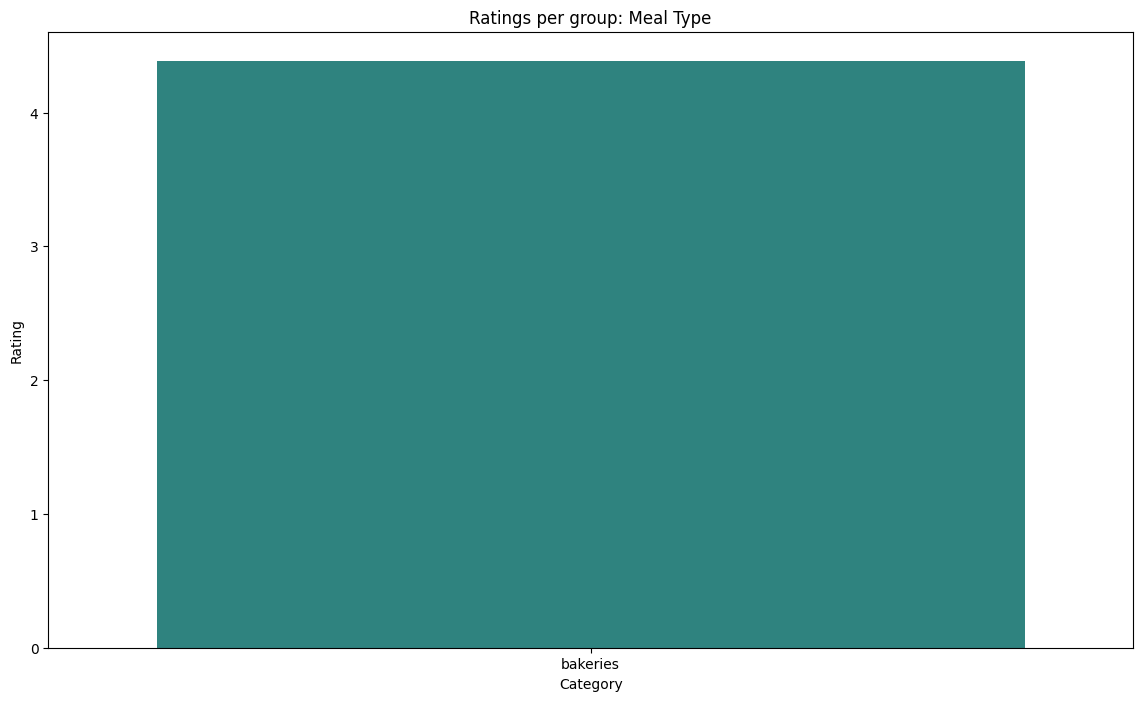

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3313449418.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=filtered_df, palette='viridis')


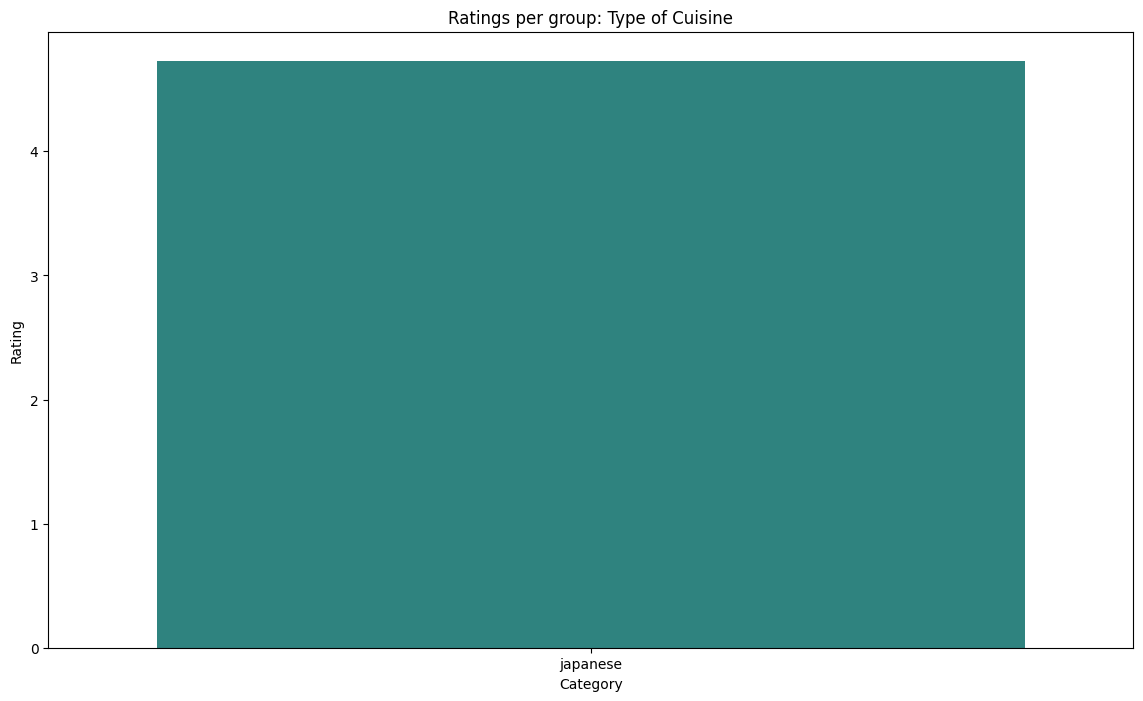

In [165]:
# Make a bar plot for each group attribute
for group in mean_ratings['group_category'].unique():
    filtered_df = mean_ratings[mean_ratings['group_category'] == group]
    filtered_df[['categories_list', 'rating']]
    filtered_df = filtered_df.sort_values(by=['rating'], ascending=False)

    plt.figure(figsize=(14, 8))
    plt.title(f'Ratings per group: {group}')
    sns.barplot(x='categories_list', y='rating', data=filtered_df, palette='viridis')
    plt.xlabel('Category')
    plt.ylabel('Rating')

    plt.show()
    
mean_ratings = mean_ratings[mean_ratings['rating'] >= 3.6]

#### Replicating steps aboven keeping reviews with utility  >= 2

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3139865404.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')


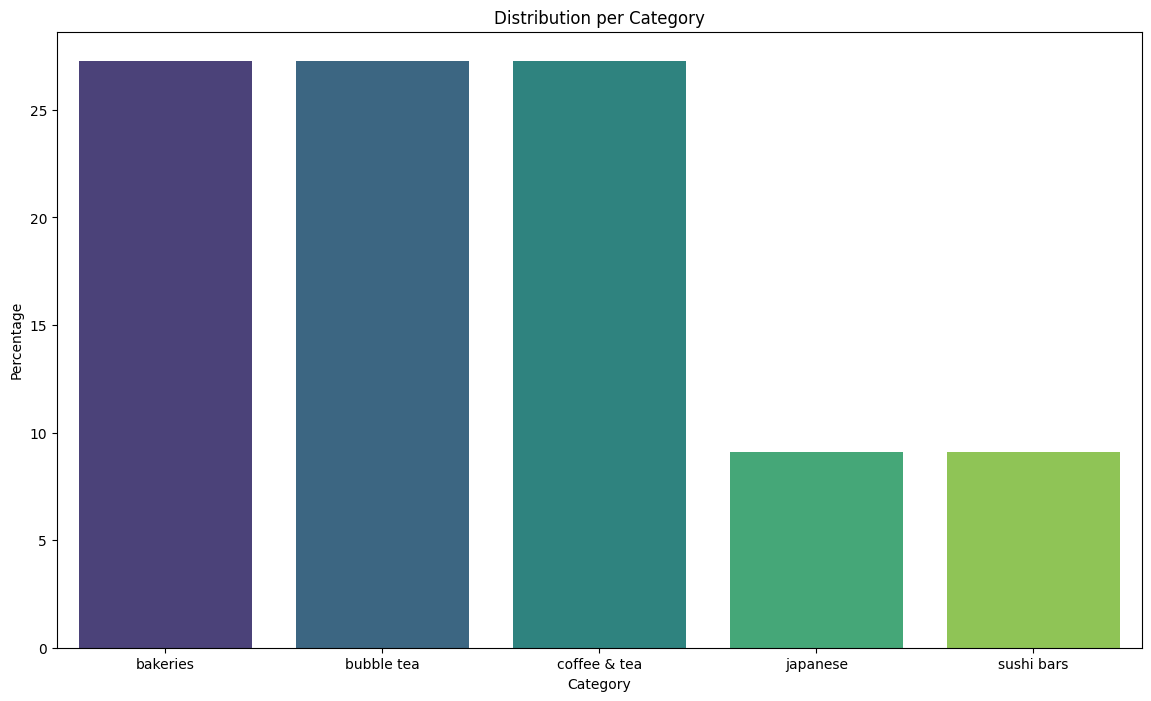

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3139865404.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')


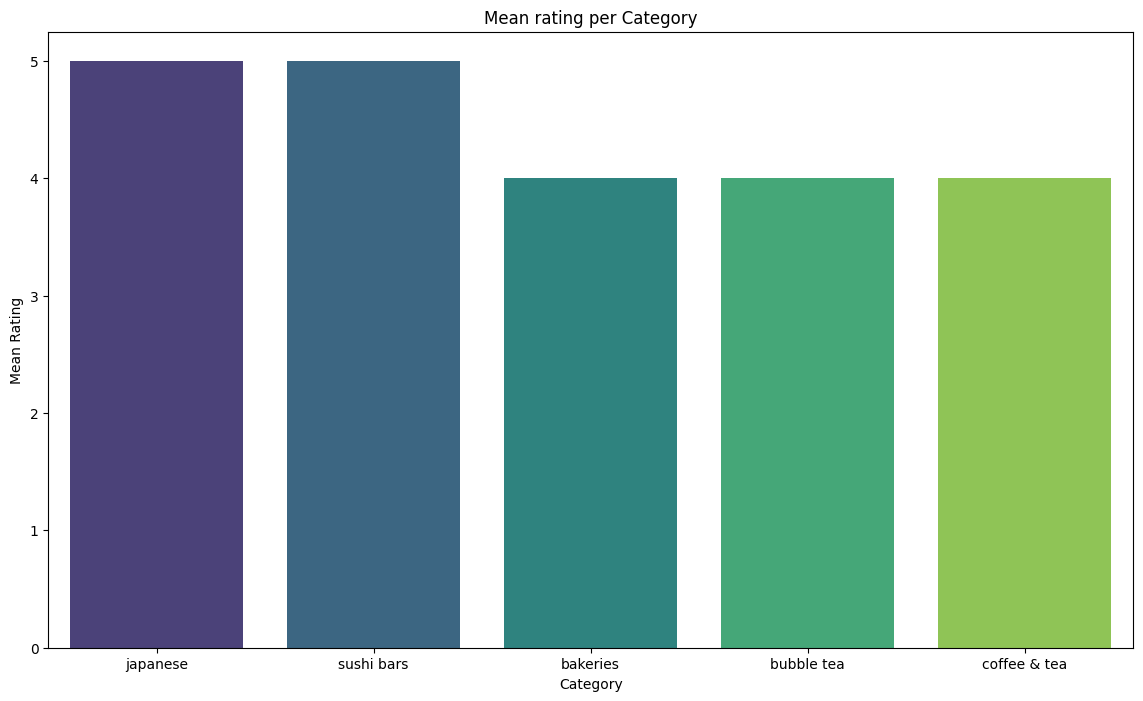

In [129]:
# Keep score in useful >= 2
df_data_utility = categories_individ_df[categories_individ_df['useful'] >= 2]

# Percentage
category_counts = df_data_utility['categories_list'].value_counts()
category_percent = (category_counts / category_counts.sum()) * 100

# Plot
category_perct_df = category_percent.reset_index()
category_perct_df.columns = ['category', 'percentage']
plt.figure(figsize=(14, 8))
sns.barplot(x='category', y='percentage', data=category_perct_df, palette='viridis')
plt.title('Distribution per Category')
plt.xlabel('Category')
plt.ylabel('Percentage')
plt.show()


# Plot
mean_ratings = df_data_utility.groupby('categories_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(14, 8))
plt.title('Mean rating per Category')
sns.barplot(x='categories_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Category')
plt.ylabel('Mean Rating')
plt.show()

# See TO DO....
### Analyzing Atributes


In [130]:
# Reinitializing the dataset
df_data = df_data_full.copy()
attribute_individ_df = df_data.explode('attributes_list')
attribute_counts = attribute_individ_df['attributes_list'].value_counts()
attribute_counts


# Put attributes in a set
all_attributes = set(np.concatenate(df_data.attributes_list.values).ravel()) #df_data.categories_list.values.flatten()
df_data.attributes_list.values
all_attributes

# Group attributes  
                                                                                # TO DO: DEFINE THE GROUPS !
group_names = ["Pricing", "Service Style", "Location", "Beverage", "Meal Times", "Amenities"]
all_attributes = {"NoiseLevel", "BusinessAcceptsCreditCards", "BusinessParking","RestaurantsTakeOut"}
Attribute_groups = {}

# Classify the attributes according to the groups
for category in all_attributes:
    output = classifier(category, group_names)
    Attribute_groups[category] = output['labels'][0]

attribute_individ_df["group_attribute"] = attribute_individ_df["attributes_list"].map(Attribute_groups)

#### Frequency of items in attributes

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\1876579920.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes', y='percentage', data=attribute_percentages_df, palette='viridis')


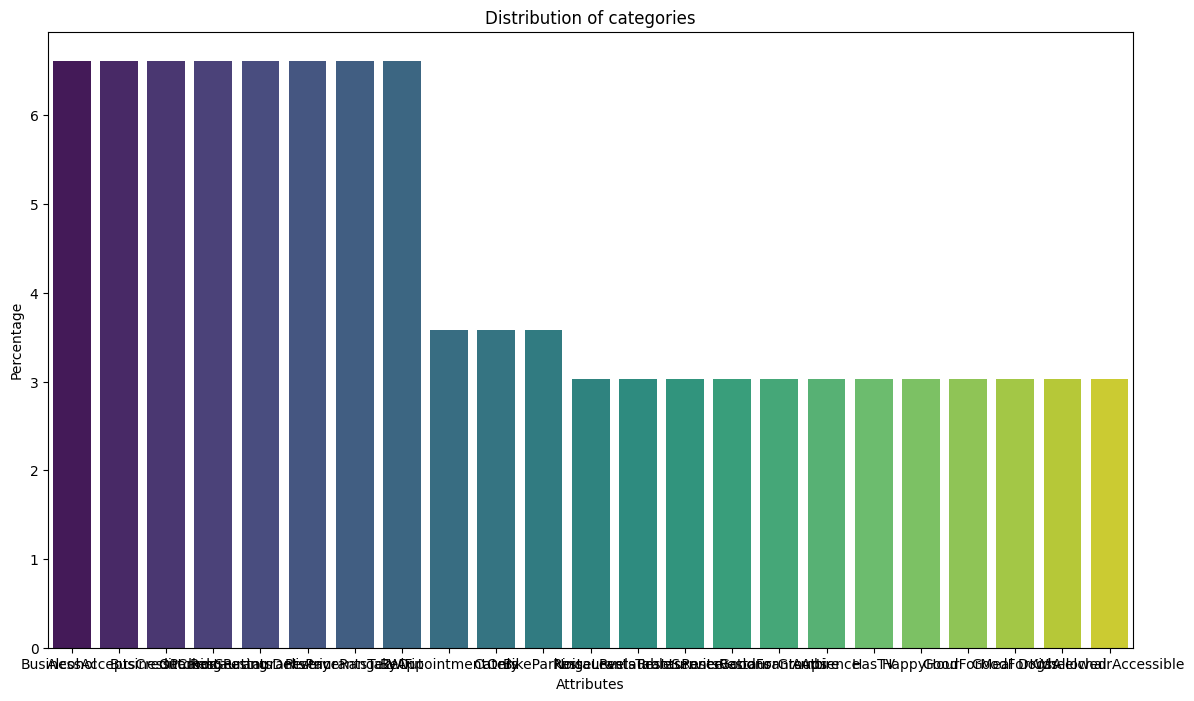

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\1876579920.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=mean_ratings, palette='viridis')


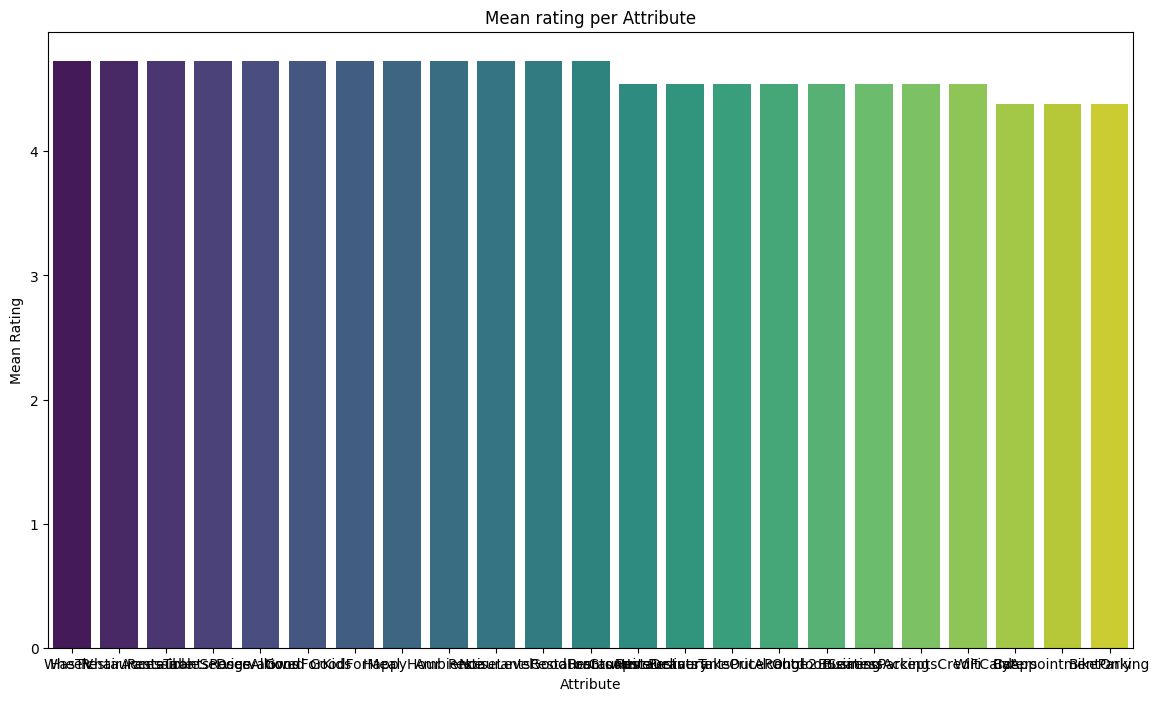

In [ ]:
# Calculate the percentage distribution
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot the results
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ['attributes', 'percentage']
plt.figure(figsize=(14, 8))
plt.title('Distribution of categories')
sns.barplot(x='attributes', y='percentage', data=attribute_percentages_df, palette='viridis')
plt.xlabel('Attributes')
plt.ylabel('Percentage')
plt.show()


######################
# AVERAING PER CATEGORY
######################

# Plot the results
mean_ratings = attribute_individ_df.groupby('attributes_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(14, 8))
plt.title('Mean rating per Attribute')
sns.barplot(x='attributes_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Mean Rating')
plt.show()

#### Average rating per category

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3325219131.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attribute', y='percentage', data=attribute_percentages_df, palette='viridis')


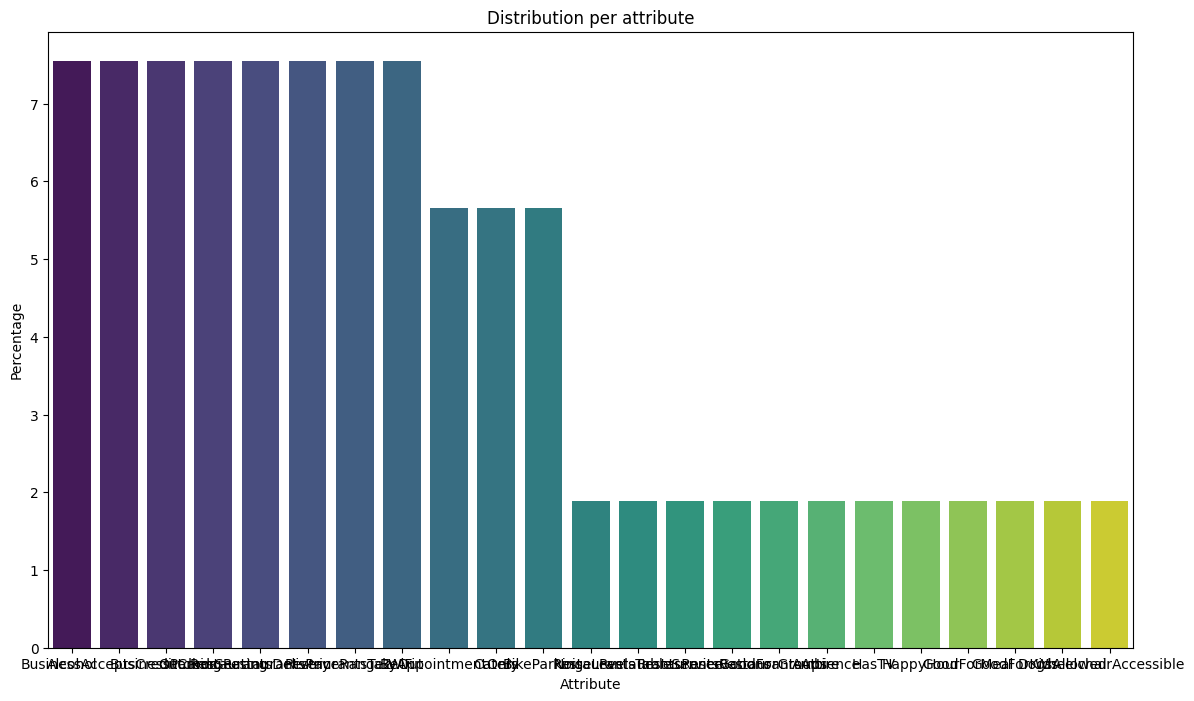

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\3325219131.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=mean_ratings, palette='viridis')


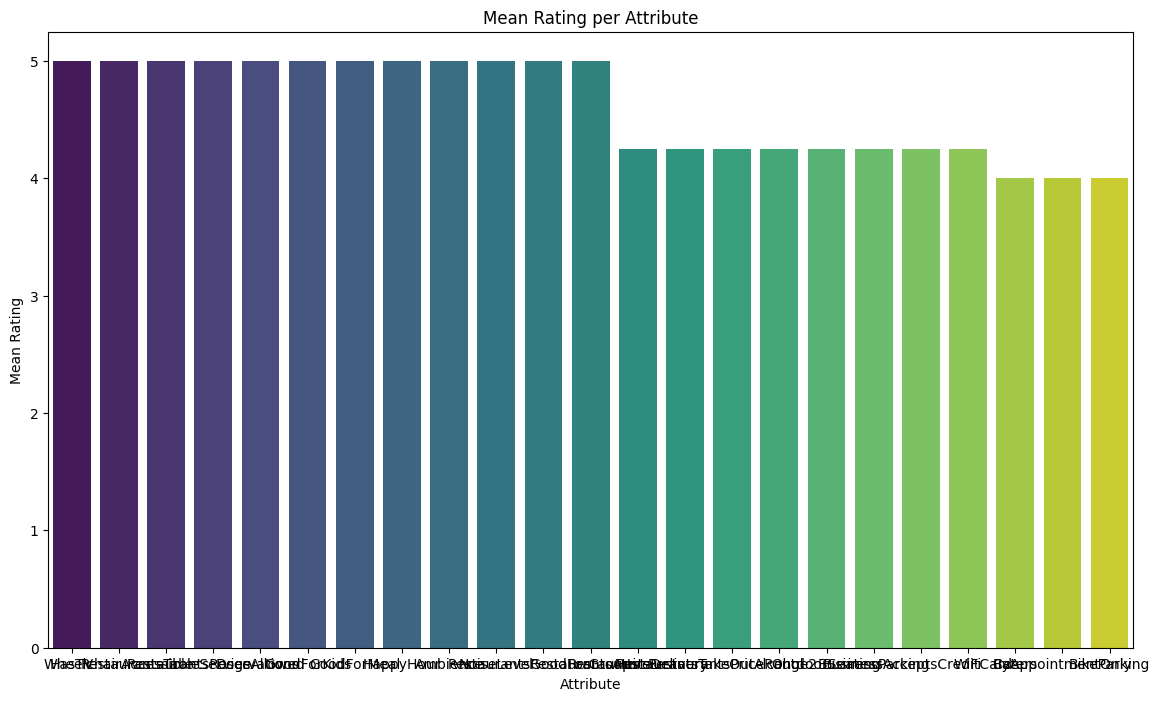

In [134]:
# Keep utility score >= 2
df_data_utility = attribute_individ_df[attribute_individ_df['useful'] >= 2]

attribute_counts = df_data_utility['attributes_list'].value_counts()
attribute_percentages = (attribute_counts / attribute_counts.sum()) * 100

# Plot
attribute_percentages_df = attribute_percentages.reset_index()
attribute_percentages_df.columns = ['attribute', 'percentage']
plt.figure(figsize=(14, 8))
plt.title('Distribution per attribute')
sns.barplot(x='attribute', y='percentage', data=attribute_percentages_df, palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Percentage')
plt.show()


# Plot
mean_ratings = df_data_utility.groupby('attributes_list')['rating'].mean().reset_index()
mean_ratings = mean_ratings.sort_values(by='rating', ascending=False)
plt.figure(figsize=(14, 8))
plt.title('Mean Rating per Attribute')
sns.barplot(x='attributes_list', y='rating', data=mean_ratings, palette='viridis')
plt.xlabel('Attribute')
plt.ylabel('Mean Rating')
plt.show()

#### PLOT PER ATTRIBUTE

In [133]:
mean_ratings

,group_attribute,attributes_list,rating


In [139]:
# Mean rating per attribute
mean_ratings["group_attribute"] = mean_ratings["attributes_list"].map(Attribute_groups)
mean_ratings = mean_ratings.groupby(['group_attribute', 'attributes_list'])['rating'].mean().reset_index()
mean_ratings = mean_ratings[mean_ratings['rating'] >= 3.6]
mean_ratings

,group_attribute,attributes_list,rating
0,Amenities,BusinessParking,4.25
1,Beverage,RestaurantsTakeOut,4.25
2,Service Style,BusinessAcceptsCreditCards,4.25
3,Service Style,NoiseLevel,5.00


C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\59979322.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=filtered_df, palette='viridis')


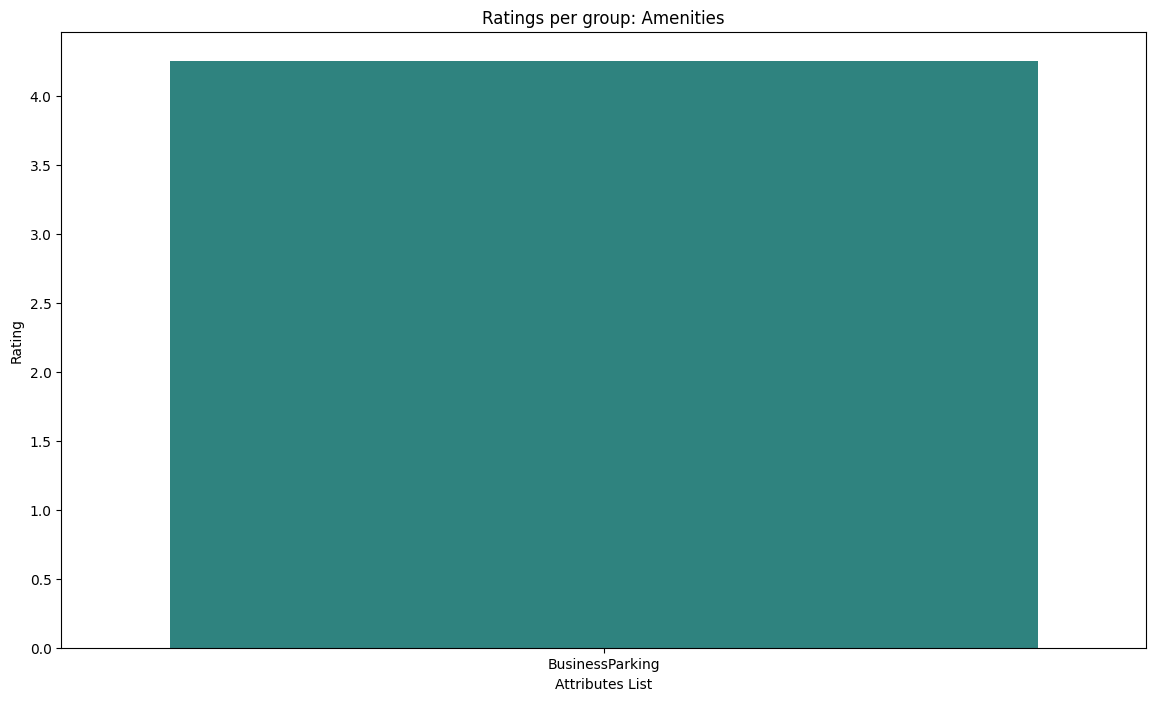

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\59979322.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=filtered_df, palette='viridis')


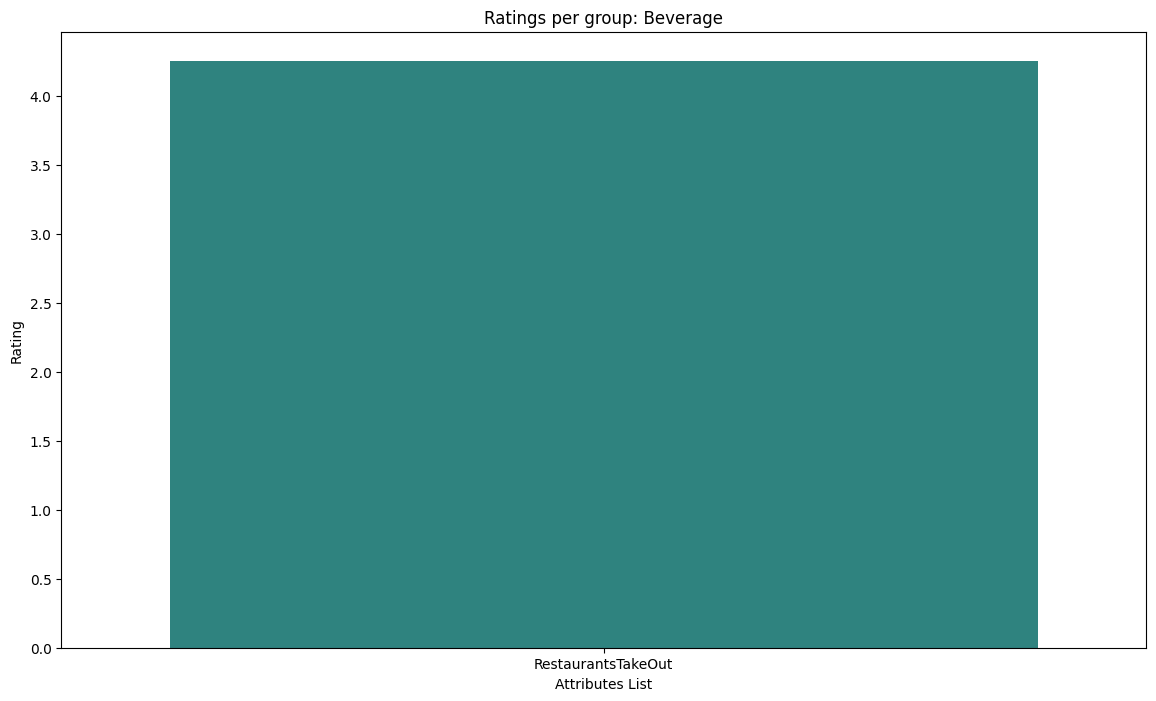

C:\Users\Alexis\AppData\Local\Temp\ipykernel_18228\59979322.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='attributes_list', y='rating', data=filtered_df, palette='viridis')


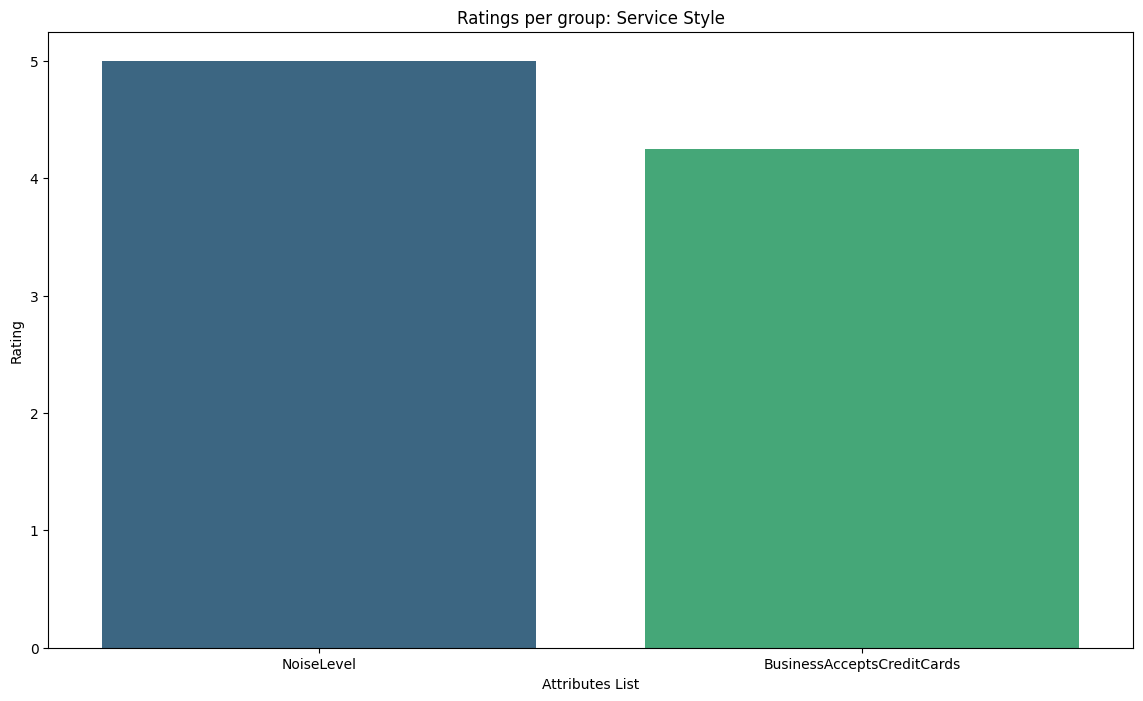

In [142]:
# Make a bar plot for each group attribute
for group in mean_ratings['group_attribute'].unique():
    filtered_df = mean_ratings[mean_ratings['group_attribute'] == group]
    filtered_df[['attributes_list', 'rating']]
    filtered_df = filtered_df.sort_values(by=['rating'], ascending=False)

    plt.figure(figsize=(14, 8))
    plt.title(f'Ratings per group: {group}')
    sns.barplot(x='attributes_list', y='rating', data=filtered_df, palette='viridis')
    plt.xlabel('Attributes List')
    plt.ylabel('Rating')

    plt.show()